In [65]:
import pandas as pd
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from diffusers import UNet2DModel
import ast
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



In [66]:
# Data Processing Functions
def fix_missing_commas(vector_string):
    """Fix missing commas in lyrics vector strings."""
    content = vector_string.strip("[]")
    fixed_content = "[" + re.sub(r"\s+", ", ", content) + "]"
    return fixed_content

def convert_to_tensor(row):
    """Convert row data to a numpy array."""
    try:
        numeric_cols = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                       'Acousticness', 'Instrumentalness', 'Liveness', 
                       'Valence', 'Tempo']
        
        attributes = row[numeric_cols].tolist()
        lyrics_vector = row['lyrics_vector']
        
        if isinstance(lyrics_vector, str):
            lyrics_vector = lyrics_vector.strip('[]').split()
            lyrics_vector = [float(x) for x in lyrics_vector]
        
        attributes.extend(lyrics_vector)
        return np.array(attributes, dtype=np.float32)
    except Exception as e:
        logger.error(f"Error converting row to tensor: {e}")
        raise

def process_dataframe(df):
    """Process the DataFrame to prepare it for the model."""
    try:
        df = df.copy()
        
        # Verify required columns exist
        required_cols = ['ID', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 
                        'Acousticness', 'Instrumentalness', 'Liveness', 
                        'Valence', 'Tempo', 'lyrics_vector']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Process lyrics vector
        df['lyrics_vector'] = df['lyrics_vector'].apply(fix_missing_commas)
        df['lyrics_vector'] = df['lyrics_vector'].apply(ast.literal_eval)
        
        # Create image paths
        df['Image'] = 'track_images/' + df['ID'].astype(str) + '.jpg'
        
        # Verify images exist
        missing_images = [row['Image'] for _, row in df.iterrows() 
                         if not os.path.exists(row['Image'])]
        if missing_images:
            logger.warning(f"Missing {len(missing_images)} images")
            # Filter out rows with missing images
            df = df[df['Image'].apply(os.path.exists)]
            if len(df) == 0:
                raise ValueError("No valid images found in the dataset")
        
        # Create attributes
        df['attributes'] = df.apply(convert_to_tensor, axis=1)
        
        # Clean up
        df.drop(columns=['ID', 'lyrics_vector'], inplace=True)
        
        return df
    except Exception as e:
        logger.error(f"Error processing DataFrame: {e}")
        raise

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            image_path = row['Image']
            
            # Verify image exists
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image not found: {image_path}")
            
            # Load and process image
            with Image.open(image_path) as img:
                image = img.convert('RGB')
                if self.transform:
                    image = self.transform(image)
            
            # Convert attributes to tensor
            attributes = torch.tensor(row['attributes'], dtype=torch.float32)
            
            return image, attributes
        except Exception as e:
            logger.error(f"Error loading item {idx}: {e}")
            raise

In [67]:
# Conditional Diffusion Model
class ConditionalDiffusionModel(nn.Module):
    def __init__(self, attribute_size, sample_size=128, num_channels=3):
        super().__init__()
        self.unet = UNet2DModel(
            sample_size=sample_size,
            in_channels=num_channels + 1,  # +1 for condition channel
            out_channels=num_channels,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.attribute_embedding = nn.Linear(attribute_size, sample_size * sample_size)

    def forward(self, x, timesteps, attributes):
        # Reshape attributes to spatial condition
        attributes = self.attribute_embedding(attributes)
        attributes = attributes.view(-1, 1, 128, 128)
        
        # Concatenate input and condition
        x_with_attributes = torch.cat([x, attributes], dim=1)
        return self.unet(x_with_attributes, timesteps).sample

# Visualization Functions
def show_images(images, title):
    """Display a batch of images."""
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        if not isinstance(axs, np.ndarray):
            axs = [axs]
        axs[i].imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

In [68]:
def train_and_visualize(model, dataloader, optimizer, criterion, epochs=10, display_step=100):
    """Train the model and visualize results periodically."""
    device = next(model.parameters()).device
    model.train()
    
    for epoch in range(epochs):
        for step, (images, attributes) in enumerate(dataloader):
            images = images.to(device)
            attributes = attributes.to(device)
            
            optimizer.zero_grad()
            
            # Generate random timesteps
            batch_size = images.shape[0]
            timesteps = torch.randint(0, 1000, (batch_size,), device=device)
            
            # Forward pass
            predicted_images = model(images, timesteps, attributes)
            loss = criterion(predicted_images, images)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Visualize progress
            if step % display_step == 0:
                print(f"Epoch {epoch}, Step {step}, Loss: {loss.item():.4f}")
                with torch.no_grad():
                    original = images[0]
                    generated = predicted_images[0]
                    show_images([original, generated], 
                              f'Epoch {epoch}, Step {step}, Loss: {loss.item():.4f}')

INFO:__main__:Loading data...
INFO:__main__:Processed 100 valid samples


Epoch 0, Step 0, Loss: 0.5319


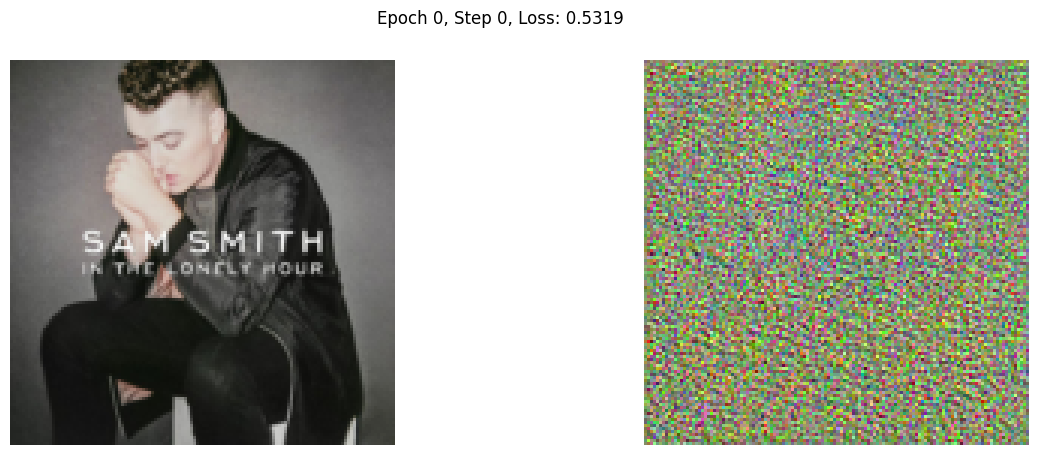

Epoch 1, Step 0, Loss: 0.3415


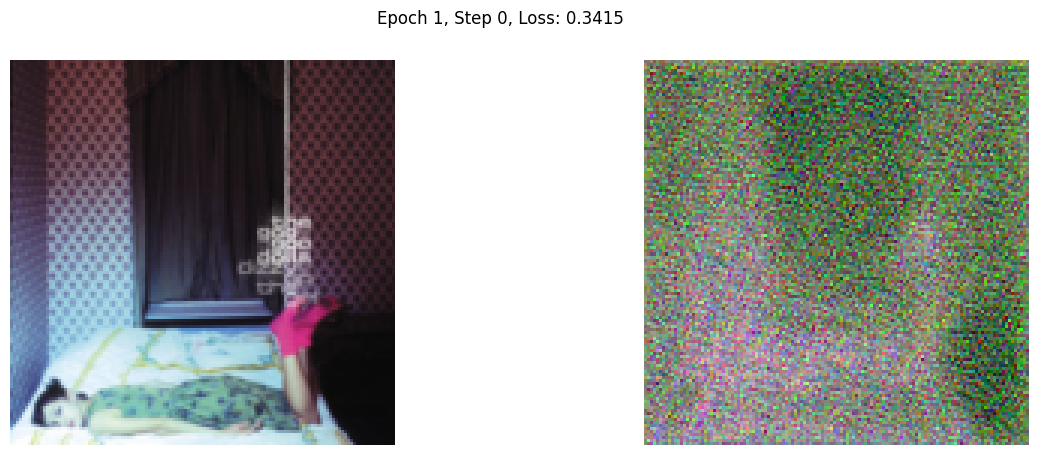

Epoch 2, Step 0, Loss: 0.2475


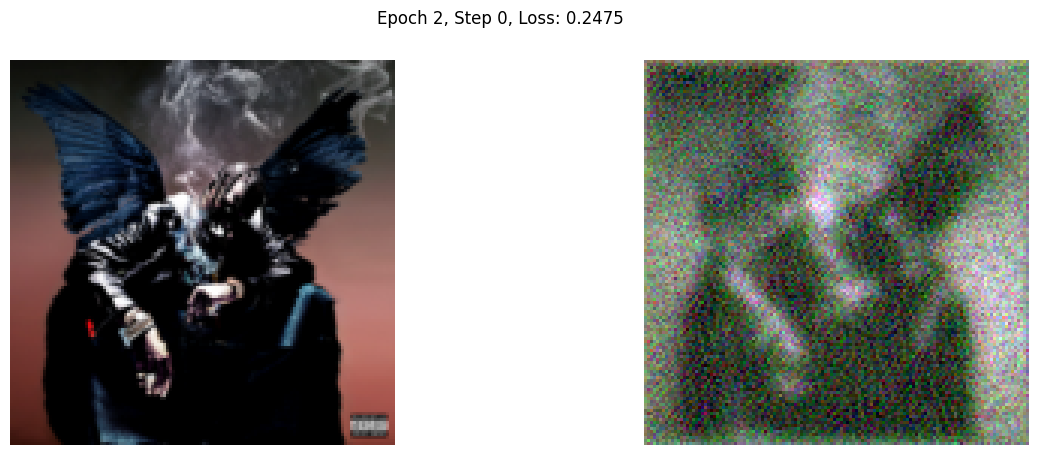

Epoch 3, Step 0, Loss: 0.1633


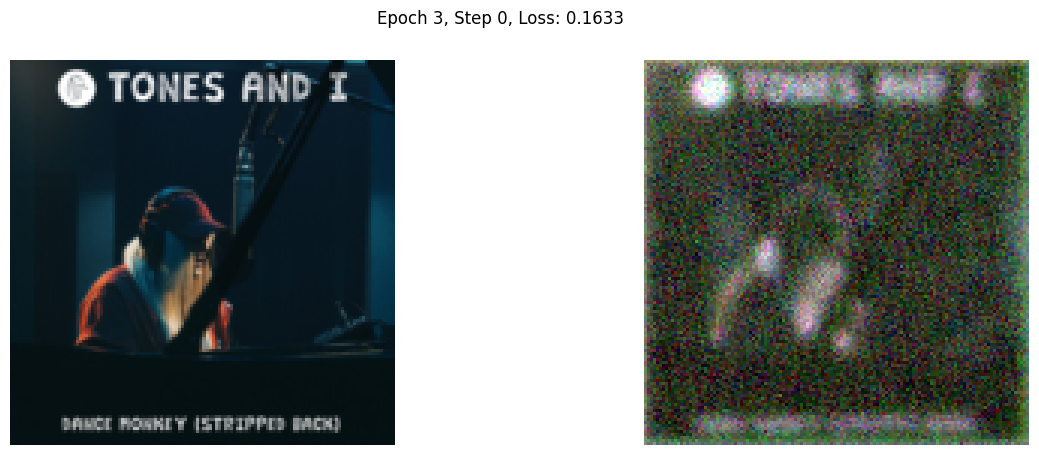

Epoch 4, Step 0, Loss: 0.1234


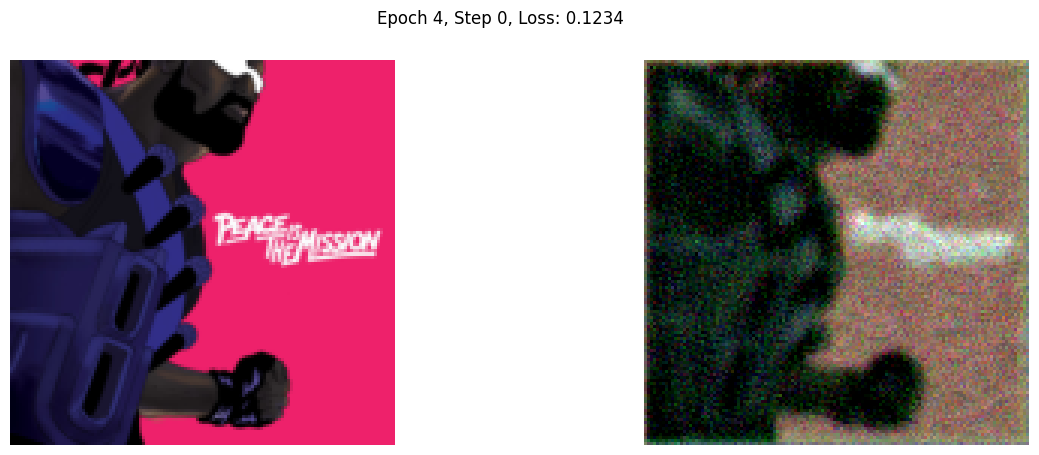

Epoch 5, Step 0, Loss: 0.1102


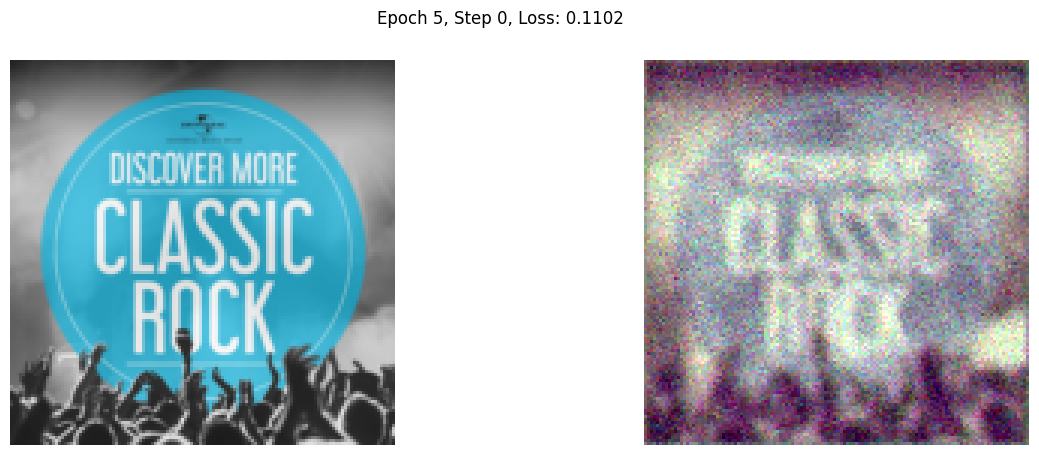

Epoch 6, Step 0, Loss: 0.0798


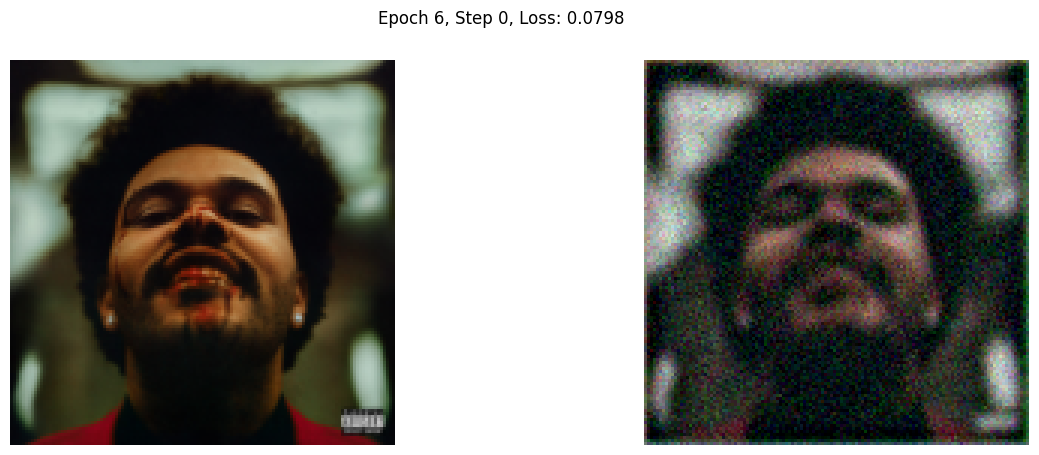

Epoch 7, Step 0, Loss: 0.0827


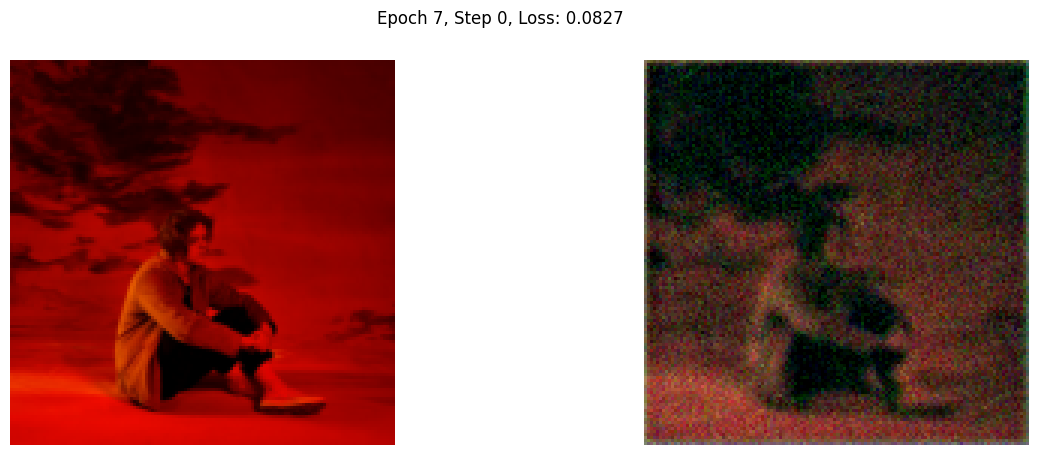

Epoch 8, Step 0, Loss: 0.0785


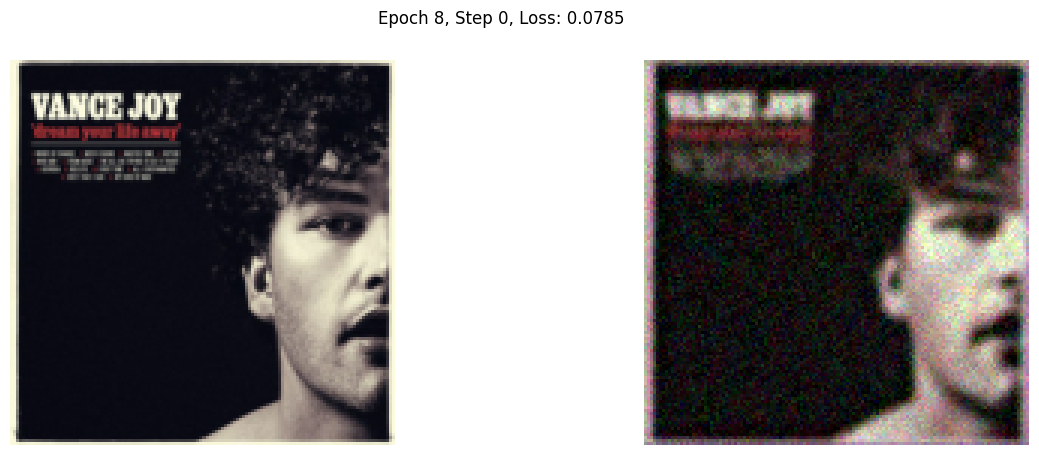

Epoch 9, Step 0, Loss: 0.0735


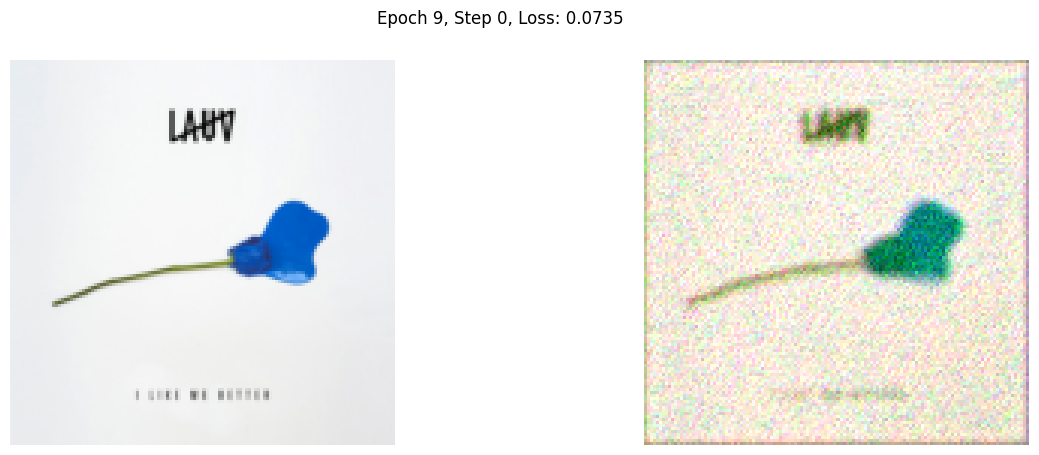

In [69]:
def main():
    try:
        # Load and process data
        logger.info("Loading data...")
        df = pd.read_csv('df.csv')
        processed_df = process_dataframe(df)
        logger.info(f"Processed {len(processed_df)} valid samples")
        
        # Create dataset and dataloader
        dataset = CustomDataset(processed_df)
        dataloader = DataLoader(
            dataset,
            batch_size=32,
            shuffle=True,
            num_workers=0,  # Set to 0 for debugging
            persistent_workers=False,
            pin_memory=True
        )
        
        # Initialize model and optimizer
        attribute_size = len(processed_df['attributes'].iloc[0])
        model = ConditionalDiffusionModel(attribute_size=attribute_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.MSELoss()
        
        # Move to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        # Train model
        train_and_visualize(model, dataloader, optimizer, criterion, epochs=10)
        
    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise

if __name__ == "__main__":
    main()